In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import mdtraj as md
import math
from cgae import *
import numpy as np
import sys
### Some path name
sys.path.insert(0, '/some/path/name')

from nff.utils.fixing_pbc import get_box_dimensions_pbc, split_mol, trajconv, combine_mol, save_traj, write_traj
from nff.utils.utilities import reorganize

In [2]:
# hyperparameters 
par = {}
par["n_atom"] = 10 # 25 in the case of using all the atoms, 10 in the case of using only the heavy atoms
par["N_cg"] = 4
par["lr"]  = 1e-4
par["batch_size"] = 20  
par["Tstart"] = 4.0      # starting temperature 
par["max_epoch"] = 40 
par["n_mol"] = 20         # number of molecules, 
par["epoch_regularize"] = 40    # first epoch to include instataneous force regularization
par["rho"] = 0.001       # relative weight for force regularization
par["decay_ratio"] = 0.4 # the decay rate for the temperature annealing 

device = 'cuda:0'

### If using all of the atoms of the cation for coarse-graining
# otp_element = ['N', 'C', 'N', 'C', 'C', 'C', 'H', 'C', 'H', 'H', 'H',
#                'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'H', 'H', 'H']

### If using only the heavy atoms for coarse-graining
otp_element = ['N', 'C', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C']

In [3]:
N = 300
ils_mol = [[7, 6, 7, 6, 6, 6, 1, 6, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1],[5, 9, 9, 9, 9]]
N_cation = 25
N_anion = 5
N_atom = N_cation + N_anion
PATH = './data/'
xyz_name = '{}/unif_batch_400_p300_T300_xyz.xyz'.format(PATH)
force_name = '{}/unif_batch_400_p300_T300_force.dat'.format(PATH)
N_cg = par["N_cg"]

In [4]:
### The lammps files comes in the format of 
ils_matrix, timestep_amount = split_mol(N, N_cation, N_anion, xyz_name)
cell = get_box_dimensions_pbc(force_name, timestep_amount)
converted_mol = []
converted_mol = trajconv(N, ils_mol[0], cell, mol_matrix=ils_matrix[0])
force_full = reorganize(N_cation, N_anion, N, force_name, 'force')

Done sorting


In [5]:
### If using all of the atoms of the cation for coarse-graining
# traj = converted_mol.reshape(-1, 300, 25, 4)
# traj = traj[:, :, :, 1:]
# force = force_full[:, :, :25, :]

### If using only the heavy atoms for coarse-graining
traj = converted_mol.reshape(-1, N, 25, 4)
traj = traj[:, :, (0,1,2,3,4,5,7,13,16,19), 1:]
force = force_full[:, :, (0,1,2,3,4,5,7,13,16,19), :]

In [6]:
N_cg = par["N_cg"]
n_atom = par["n_atom"]
n_mol = par["n_mol"]
batch_size = par["batch_size"]
n_batch = int(traj.shape[0] // batch_size)
n_sample = n_batch * batch_size
xyz = traj[:n_sample].reshape(-1, batch_size, n_atom, 3)
force = force[:n_sample].reshape(-1, batch_size, n_atom, 3)
device = "cuda:0"

In [7]:
Encoder = encoder(in_dim=par["n_atom"], out_dim=par["N_cg"], hard=False, device=device).to(device)
Decoder = decoder(in_dim=par["N_cg"], out_dim=par["n_atom"]).to(device)

# Initialize Temperature Scheduler for Gumbel softmax 
t0 = par["Tstart"]
tmin = 0.2
temp = np.linspace(0, par["max_epoch"], par["max_epoch"] )

decay_epoch = int(par["max_epoch"] * par["decay_ratio"])
t_sched = t0 * np.exp(-temp/decay_epoch ) +  tmin
t_sched = torch.Tensor(t_sched).to(device)


# Initialize Optimizer 
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(list(Encoder.parameters()) + list(Decoder.parameters()), lr=par["lr"]) 

loss_log = []
loss_ae_log = []
loss_fm_log = []

epoch 0 reconstruction  5107.942 instantaneous forces 0.015  tau  4.200


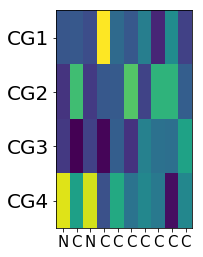

epoch 1 reconstruction  1.981 instantaneous forces 0.015  tau  3.952


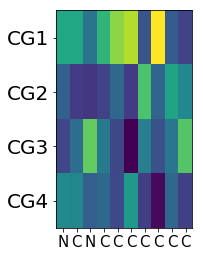

epoch 2 reconstruction  1.855 instantaneous forces 0.017  tau  3.719


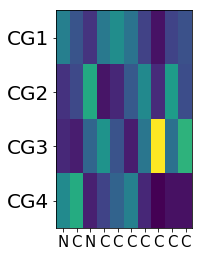

epoch 3 reconstruction  1.689 instantaneous forces 0.020  tau  3.500


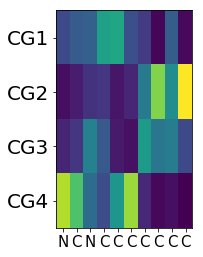

epoch 4 reconstruction  1.474 instantaneous forces 0.023  tau  3.295


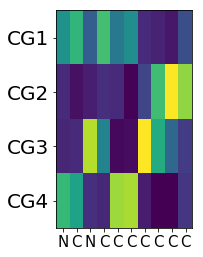

epoch 5 reconstruction  1.222 instantaneous forces 0.025  tau  3.103


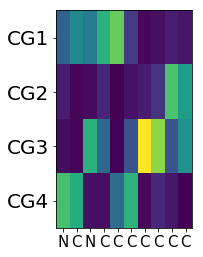

epoch 6 reconstruction  0.965 instantaneous forces 0.028  tau  2.923


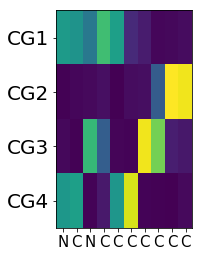

epoch 7 reconstruction  0.733 instantaneous forces 0.030  tau  2.754


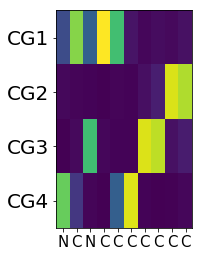

epoch 8 reconstruction  0.548 instantaneous forces 0.032  tau  2.595


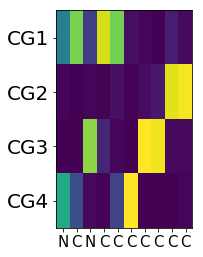

epoch 9 reconstruction  0.415 instantaneous forces 0.033  tau  2.446


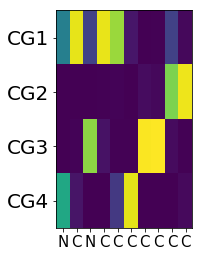

epoch 10 reconstruction  0.326 instantaneous forces 0.034  tau  2.307


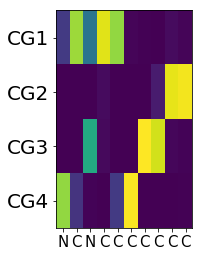

epoch 11 reconstruction  0.270 instantaneous forces 0.035  tau  2.176


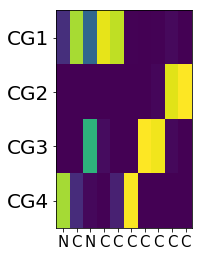

epoch 12 reconstruction  0.237 instantaneous forces 0.036  tau  2.053


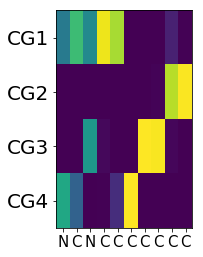

epoch 13 reconstruction  0.217 instantaneous forces 0.037  tau  1.938


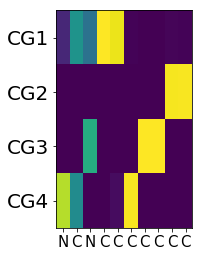

epoch 14 reconstruction  0.205 instantaneous forces 0.037  tau  1.830


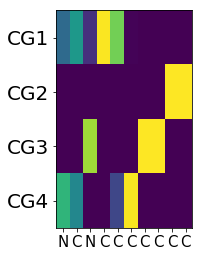

epoch 15 reconstruction  0.195 instantaneous forces 0.038  tau  1.729


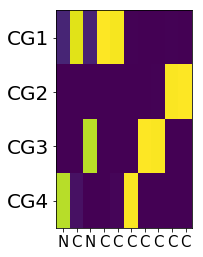

epoch 16 reconstruction  0.186 instantaneous forces 0.038  tau  1.634


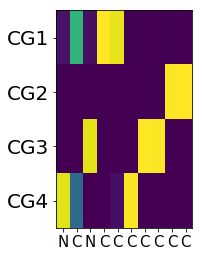

epoch 17 reconstruction  0.178 instantaneous forces 0.038  tau  1.545


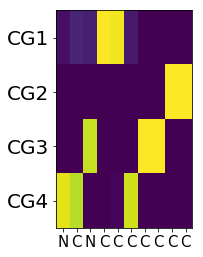

epoch 18 reconstruction  0.169 instantaneous forces 0.038  tau  1.462


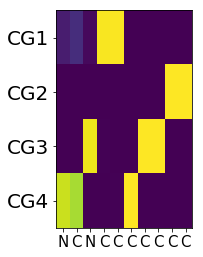

epoch 19 reconstruction  0.161 instantaneous forces 0.038  tau  1.383


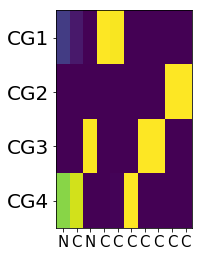

epoch 20 reconstruction  0.153 instantaneous forces 0.038  tau  1.310


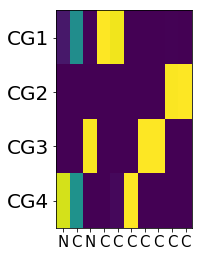

epoch 21 reconstruction  0.146 instantaneous forces 0.038  tau  1.241


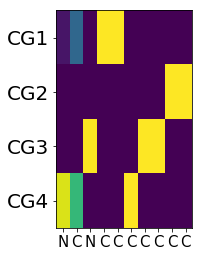

epoch 22 reconstruction  0.138 instantaneous forces 0.038  tau  1.176


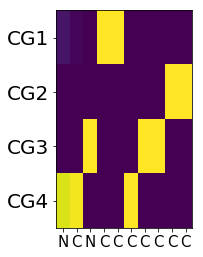

epoch 23 reconstruction  0.131 instantaneous forces 0.038  tau  1.116


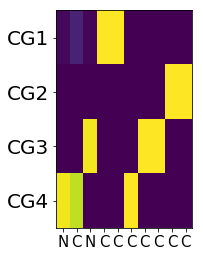

epoch 24 reconstruction  0.123 instantaneous forces 0.038  tau  1.059


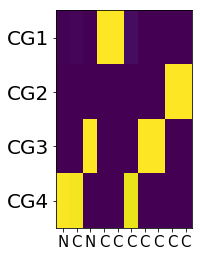

epoch 25 reconstruction  0.117 instantaneous forces 0.038  tau  1.006


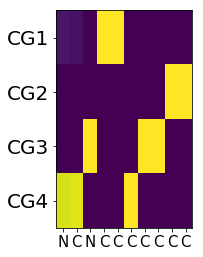

epoch 26 reconstruction  0.110 instantaneous forces 0.038  tau  0.956


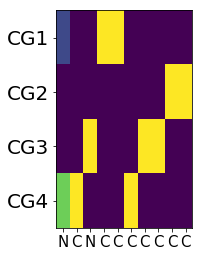

epoch 27 reconstruction  0.104 instantaneous forces 0.038  tau  0.909


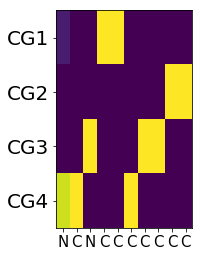

epoch 28 reconstruction  0.098 instantaneous forces 0.038  tau  0.865


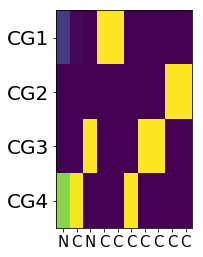

epoch 29 reconstruction  0.093 instantaneous forces 0.038  tau  0.823


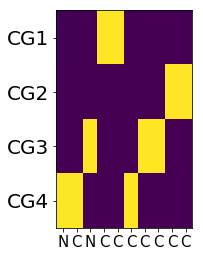

epoch 30 reconstruction  0.088 instantaneous forces 0.038  tau  0.785


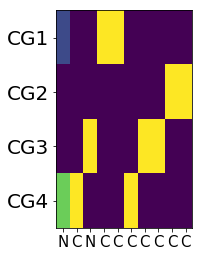

epoch 31 reconstruction  0.083 instantaneous forces 0.038  tau  0.748


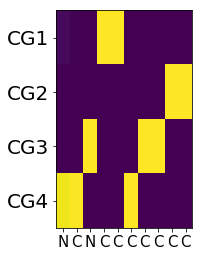

epoch 32 reconstruction  0.078 instantaneous forces 0.038  tau  0.714


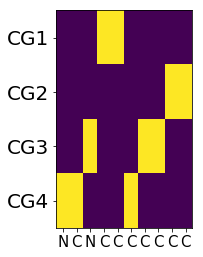

epoch 33 reconstruction  0.074 instantaneous forces 0.038  tau  0.682


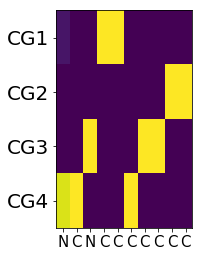

epoch 34 reconstruction  0.070 instantaneous forces 0.038  tau  0.652


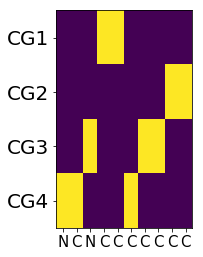

epoch 35 reconstruction  0.066 instantaneous forces 0.038  tau  0.624


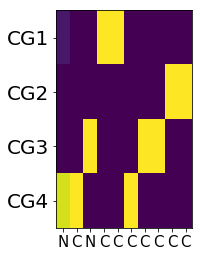

epoch 36 reconstruction  0.063 instantaneous forces 0.038  tau  0.598


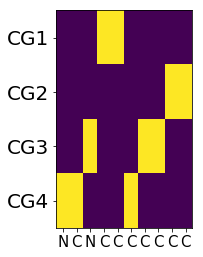

epoch 37 reconstruction  0.060 instantaneous forces 0.038  tau  0.573


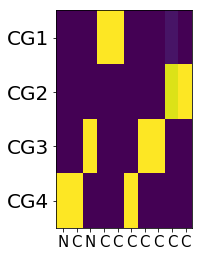

epoch 38 reconstruction  0.057 instantaneous forces 0.038  tau  0.550


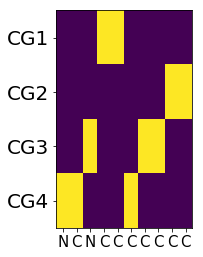

epoch 39 reconstruction  0.055 instantaneous forces 0.038  tau  0.528


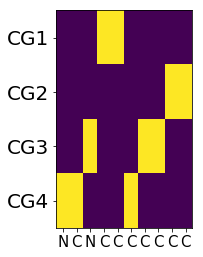

In [8]:
for epoch in range(par["max_epoch"]):  
# for epoch in range(1): 
        loss_epoch = 0.0  
        loss_ae_epoch = 0.0
        loss_fm_epoch = 0.0
        
            
        for i, batch in enumerate(xyz):
            batch = torch.Tensor(batch.reshape(-1, n_atom, 3)).to(device) 
            cg_xyz = Encoder(batch, t_sched[epoch])
            CG = gumbel_softmax(Encoder.weight1.t(), t_sched[epoch] * 0.7, device=device).t()

            decoded = Decoder(cg_xyz)
            loss_ae = criterion(decoded, batch)
            
            f0 = torch.Tensor(force[i].reshape(-1, n_atom, 3)).to(device)
            f = torch.matmul(CG, f0)
            
            if epoch > par["max_epoch"]-2:
                if i == 0:
                    forces_modified = f
                else:
                    forces_modified = torch.cat((forces_modified, f), 0)
            
            mean_force = f.pow(2).sum(2).sqrt().mean()

            loss_fm = par["rho"] * mean_force
            
            if epoch >= par["epoch_regularize"]:
                loss = loss_ae + loss_fm
            else: 
                loss = loss_ae

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
            loss_ae_epoch += loss_ae.item()
            loss_fm_epoch += loss_fm.item()
        
        loss_epoch = loss_epoch/xyz.shape[0]
        loss_ae_epoch = loss_ae_epoch/xyz.shape[0]
        loss_fm_epoch = loss_fm_epoch/xyz.shape[0]

        loss_log.append(loss_epoch)
        loss_ae_log.append(loss_ae_epoch)
        loss_fm_log.append(loss_fm_epoch)

        print("epoch %d reconstruction  %.3f instantaneous forces %.3f  tau  %.3f"  % (epoch, loss_ae_epoch, loss_fm_epoch, t_sched[epoch].item()))

        # Plot the mapping 
        CG = gumbel_softmax(Encoder.weight1.t(), t_sched[epoch], device=device).t()
        plt.imshow(CG.detach().cpu().numpy(), aspect=4)
        plt.xticks(np.arange(n_atom), otp_element, fontsize=15)
        plt.yticks(np.arange(N_cg), ["CG" + str(i+1) for i in range(N_cg)], fontsize=20)
        plt.show()

In [9]:
save_traj(Z=otp_element, traj=batch.detach().cpu().numpy(),name= 'traj_files/cg5_gt.xyz')
save_traj(Z=[1] * N_cg, traj=cg_xyz.detach().cpu().numpy(),name= 'traj_files/CG5_enc.xyz')
save_traj(Z=otp_element, traj=decoded.detach().cpu().numpy(),name='traj_files/cg5_dec.xyz')